# Problem

Using Monte Carlo methods, simulate future stock price outcomes for Apple ($AAPL) using Python. You can read more about Monte Carlo simulation (in a finance context) here.

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

In [4]:
apple = data.DataReader('AAPL', 'yahoo',start='1/1/2009')
    
apple.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,3.251429,3.041429,3.067143,3.241071,7.460152e+08,2.775246
2009-01-05,3.435000,3.311071,3.327500,3.377857,1.181608e+09,2.892373
2009-01-06,3.470357,3.299643,3.426786,3.322143,1.289310e+09,2.844666
2009-01-07,3.303571,3.223571,3.278929,3.250357,7.530488e+08,2.783197
2009-01-08,3.326786,3.215714,3.229643,3.310714,6.735008e+08,2.834879


### Solution

In [5]:
#Calculate the number of days that have elapsed in our chosen time window
time_elapsed = (apple.index[-1] - apple.index[0]).days

In [6]:
#Current price / first record (e.g. price at beginning of 2009) 
#provides us with the total growth %
total_growth = (apple['Adj Close'][-1] / apple['Adj Close'][1])

In [7]:
#Next, we want to annualize this percentage
#First, we convert our time elapsed to the # of years elapsed
number_of_years = time_elapsed / 365.0 

In [8]:
#Second, we can raise the total growth to the inverse of the # of years 
#(e.g. ~1/10 at time of writing) to annualize our growth rate
cagr = total_growth ** (1/number_of_years) - 1

In [9]:
#Now that we have the mean annual growth rate above, 
#we'll also need to calculate the standard deviation of the 
#daily price changes
std_dev = apple['Adj Close'].pct_change().std()

In [10]:
#Next, because there are roughy ~252 trading days in a year, 
#we'll need to scale this by an annualization factor
#reference: https://www.fool.com/knowledge-center/how-to-calculate-annualized-volatility.aspx

number_of_trading_days = 252
std_dev = std_dev * math.sqrt(number_of_trading_days)

In [11]:
#From here, we have our two inputs needed to generate random 
#values in our simulation
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("std_dev (standard deviation of return : )", str(round(std_dev,4)))

cagr (mean returns) :  0.3638
std_dev (standard deviation of return : ) 0.2854


### Generate random values, run Monte Carlo simulation

In [17]:
#Generate random values for 1 year's worth of trading (252 days),
#using numpy and assuming a normal distribution
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),number_of_trading_days)+1

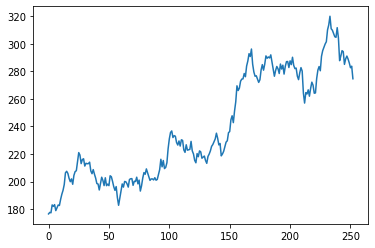

In [18]:
#Now that we have created a random series of future 
#daily return %s, we can simply apply these forward-looking
#to our last stock price in the window, effectively carrying forward 
#a price prediction for the next year

#This distribution is known as a 'random walk'

price_series = [apple['Adj Close'][-1]]

for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)

#Great, now we can plot of single 'random walk' of stock prices        
plt.plot(price_series)
plt.show()


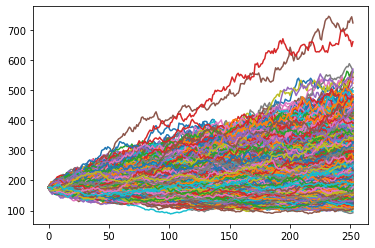

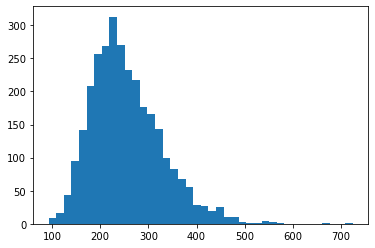

In [19]:
#Now that we've created a single random walk above, 
#we can simulate this process over a large sample size to 
#get a better sense of the true expected distribution
number_of_trials = 3000

#set up an additional array to collect all possible
#closing prices in last day of window. 
#We can toss this into a histogram
#to get a clearer sense of possible outcomes
closing_prices = []

for i in range(number_of_trials):
    #calculate randomized return percentages following our normal distribution 
    #and using the mean / std dev we calculated above
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev/math.sqrt(number_of_trading_days),
number_of_trading_days)+1
    price_series = [apple['Adj Close'][-1]]

    for j in daily_return_percentages:
        #extrapolate price out for next year
        price_series.append(price_series[-1] * j)
    
    #append closing prices in last day of window for histogram
    closing_prices.append(price_series[-1])
  
    #plot all random walks
    plt.plot(price_series)
    


plt.show()

#plot histogram
plt.hist(closing_prices,bins=40)

plt.show()

### Analyze results

In [20]:
#from here, we can check the mean of all ending prices
#allowing us to arrive at the most probable ending point
mean_end_price = round(np.mean(closing_prices),2)
print("Expected price: ", str(mean_end_price))

Expected price:  254.79


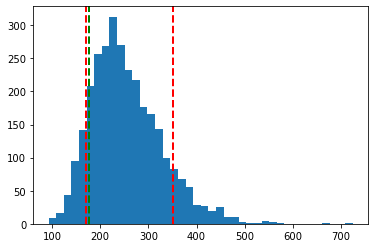

In [21]:
#lastly, we can split the distribution into percentiles
#to help us gauge risk vs. reward

#Pull top 10% of possible outcomes
top_ten = np.percentile(closing_prices,100-10)

#Pull bottom 10% of possible outcomes
bottom_ten = np.percentile(closing_prices,10);

#create histogram again
plt.hist(closing_prices,bins=40)
#append w/ top 10% line
plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)
#append w/ bottom 10% line
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)
#append with current price
plt.axvline(apple['Adj Close'][-1],color='g', linestyle='dashed',linewidth=2)

plt.show()  